# Linear Regression

In [1]:
# Import Turing and Distributions.
using Turing, Distributions

# Import RDatasets.
using RDatasets

# Import MCMCChains, Plots, and StatPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Functionality for splitting and normalizing the data.
using MLDataUtils: shuffleobs, splitobs, rescale!

# Functionality for evaluating the model predictions.
using Distances

# Set a seed for reproducibility.
using Random
Random.seed!(0)

# Hide the progress prompt while sampling.
Turing.setprogress!(true);

┌ Info: [Turing]: progress logging is enabled globally
└ @ Turing /home/anatoly/.julia/packages/Turing/YGtAo/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as true
└ @ AdvancedVI /home/anatoly/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


## Data Manipulation

In [2]:
# Import the "Default" dataset.
data = RDatasets.dataset("datasets", "mtcars");

# Show the first six rows of the dataset.
first(data, 6)

,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,String,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1


In [3]:
size(data)

(32, 12)

Clean and standardize data

In [4]:
# Remove the model column.
select!(data, Not(:Model))

# Split our dataset 70%/30% into training/test sets.
trainset, testset = splitobs(shuffleobs(data), 0.7)

# Turing requires data in matrix form.
target = :MPG
train = Matrix(select(trainset, Not(target)))
test = Matrix(select(testset, Not(target)))
train_target = trainset[:, target]
test_target = testset[:, target]

# Standardize the features.
μ, σ = rescale!(train; obsdim = 1)
rescale!(test, μ, σ; obsdim = 1)

# Standardize the targets.
μtarget, σtarget = rescale!(train_target; obsdim = 1)
rescale!(test_target, μtarget, σtarget; obsdim = 1);

## Build model

Define our linear regression

In [5]:
# Bayesian linear regression.
@model function linear_regression(x, y)
    # Set variance prior.
    σ₂ ~ truncated(Normal(0, 100), 0, Inf)
    
    # Set intercept prior.
    intercept ~ Normal(0, sqrt(3))
    
    # Set the priors on our coefficients.
    nfeatures = size(x, 2)
    coefficients ~ MvNormal(nfeatures, sqrt(10))
    
    # Calculate all the mu terms.
    mu = intercept .+ x * coefficients
    y ~ MvNormal(mu, sqrt(σ₂))
end

linear_regression (generic function with 1 method)

Sample with NUTS

In [13]:
model = linear_regression(train, train_target)
chain = sample(model, NUTS(0.65), 3_000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/anatoly/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Check convergence

In [14]:
describe(chain)

2-element Vector{ChainDataFrame}:
 Summary Statistics (12 x 8)
 Quantiles (12 x 6)

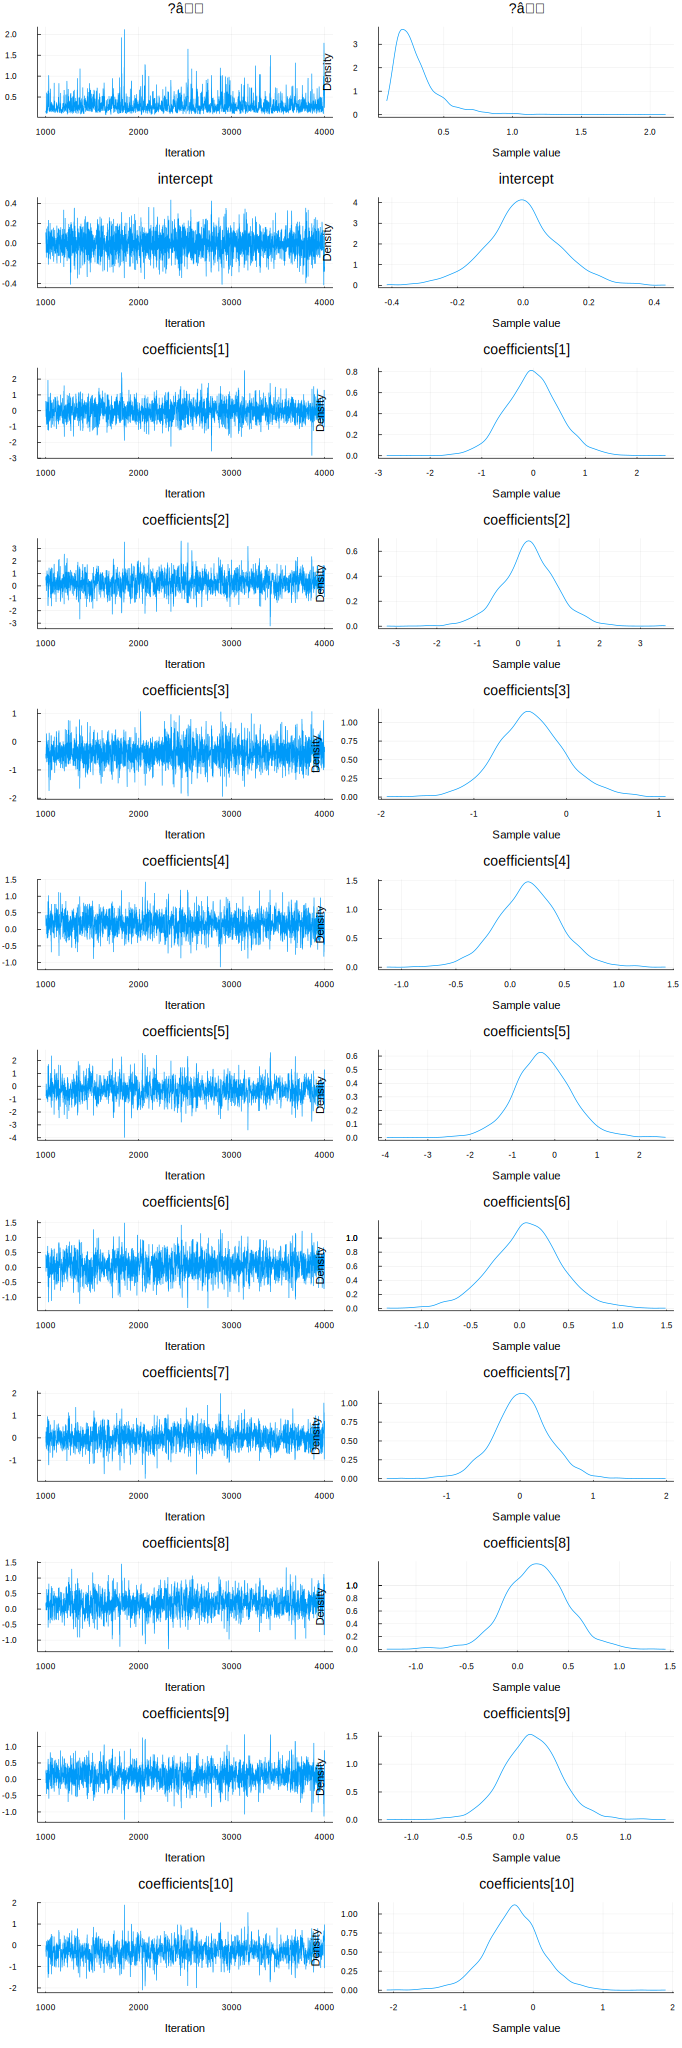

In [15]:
plot(chain)

## Compare with GLM

In [9]:
# Import the GLM package.
using GLM

# Perform multiple regression OLS.
train_with_intercept = hcat(ones(size(train, 1)), train)
ols = lm(train_with_intercept, train_target)

# Compute predictions on the training data set
# and unstandardize them.
p = GLM.predict(ols)
train_prediction_ols = μtarget .+ σtarget .* p

# Compute predictions on the test data set
# and unstandardize them.
test_with_intercept = hcat(ones(size(test, 1)), test)
p = GLM.predict(ols, test_with_intercept)
test_prediction_ols = μtarget .+ σtarget .* p;

In [10]:
# Make a prediction given an input vector.
function prediction(chain, x)
    p = get_params(chain[200:end, :, :])
    targets = p.intercept' .+ x * reduce(hcat, p.coefficients)'
    return vec(mean(targets; dims = 2))
end

prediction (generic function with 1 method)

In [11]:
# Calculate the predictions for the training and testing sets
# and unstandardize them.
p = prediction(chain, train)
train_prediction_bayes = μtarget .+ σtarget .* p
p = prediction(chain, test)
test_prediction_bayes = μtarget .+ σtarget .* p

# Show the predictions on the test data set.
DataFrame(
    MPG = testset[!, target],
    Bayes = test_prediction_bayes,
    OLS = test_prediction_ols
)

,MPG,Bayes,OLS
,Float64,Float64,Float64
1,19.2,18.2431,18.1265
2,15.0,7.00352,6.37891
3,16.4,14.0293,13.883
4,14.3,11.9439,11.7337
5,21.4,25.361,25.1916
6,18.1,20.8679,20.672
7,19.7,16.0271,15.8408
8,15.2,18.28,18.3391
9,26.0,28.0505,28.4865


We can see that our models perform similarly on training, and the Bayesian one performed better on the test set:

In [12]:
println(
    "Training set:",
    "\n\tBayes loss: ",
    msd(train_prediction_bayes, trainset[!, target]),
    "\n\tOLS loss: ",
    msd(train_prediction_ols, trainset[!, target])
)

println(
    "Test set:",
    "\n\tBayes loss: ",
    msd(test_prediction_bayes, testset[!, target]),
    "\n\tOLS loss: ",
    msd(test_prediction_ols, testset[!, target])
)

Training set:
	Bayes loss: 4.656464377167136
	OLS loss: 4.6481420856905205
Test set:
	Bayes loss: 13.33742500563363
	OLS loss: 14.796847779051523
